In [1]:
notebook_type = "kaggle"

# Импорты и константы

In [2]:
if notebook_type == "kaggle":
    main_path = "/kaggle/"
    kaggle = True
else:
    main_path = ""
    kaggle = False

In [3]:
if kaggle:
    !pip install -q torch-optimizer

In [4]:
destination_path = f"{main_path}working/"
destination_input = f"{main_path}input/"
check_data = ""

In [5]:
import gc
import hashlib
import time
import joblib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms.functional as F
from torch.utils.data import (
    DataLoader,
    Dataset,
)
import traceback
from torchvision import transforms as T
from torchvision.models import ResNet18_Weights
from tqdm import tqdm
import io
from PIL import Image

import hashlib
import time
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_optimizer as optim
from scipy.signal import savgol_filter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import (
    DataLoader,
    Dataset,
)
from tqdm import tqdm


In [6]:
import random

In [7]:
import warnings

warnings.filterwarnings(
    "ignore", category=UserWarning, module="google.protobuf.symbol_database"
)

In [8]:
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [9]:
torch.cuda.is_available()

True

In [10]:
# Настройка устройства (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Создание модели

In [11]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, dropout=0.3):
        super(Attention, self).__init__()
        # Для двунаправленной LSTM
        self.attention = nn.Linear(hidden_dim * 2, 1)
        # Dropout после линейного слоя
        self.dropout = nn.Dropout(dropout)

    def forward(self, lstm_out, mask=None):
        # lstm_out: [batch_size, seq_len, hidden_dim * 2]
        attention_scores = self.attention(lstm_out)
        # attention_scores: [batch_size, seq_len, 1]
        # Применяем Dropout
        attention_scores = self.dropout(attention_scores)

        # Если передана маска, применяем её к attention_scores
        if mask is not None:
            # Маскируем паддинг (где mask == 0)
            attention_scores = attention_scores.masked_fill(
                mask.unsqueeze(-1) == 0, float("-inf")
            )

        attention_weights = torch.softmax(attention_scores, dim=1)
        # attention_weights: [batch_size, seq_len, 1]

        # Возвращаем веса внимания
        return attention_weights

In [12]:
import torch.nn as nn

class BiLSTMModel(nn.Module):
    def __init__(
        self,
        input_dim,
        num_classes,
        hidden_dim=64,
        num_layers=2,
        dropout=0.3,
        weight_decay=0.,
        use_attention=True,  # Флаг для отключения механизма внимания
    ):
        super(BiLSTMModel, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.num_classes = num_classes
        self.use_attention = use_attention

        # Линейный слой с нужной размерностью input_dim
        self.input_embedding = nn.Linear(self.input_dim, self.hidden_dim)

        # Batch Normalization после линейного слоя
        self.batch_norm = nn.BatchNorm1d(self.hidden_dim)

        # Dropout перед LSTM слоем
        self.input_dropout = nn.Dropout(dropout)

        # Двунаправленная LSTM
        self.lstm = nn.LSTM(
            hidden_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout,
        )

        # Включаем слой внимания, если включено в параметрах
        if self.use_attention:
            self.attention = Attention(hidden_dim, dropout=dropout)

        # Dropout перед полносвязным слоем
        self.fc_dropout = nn.Dropout(dropout)

        # Линейный слой для преобразования скрытых состояний в классы
        self.fc = nn.Linear(
            hidden_dim * 2, num_classes
        )  # умножаем на 2, так как LSTM двунаправленная

    def forward(
        self,
        features=None,
        # Длина последовательностей кадров
        lengths=None,
        # Добавляем скрытое состояние для передачи между батчами
        hidden_state=None,  
        # Добавляем максу паддинга последовательности
        mask=None,
    ):
        # features.shape = [batch_size, seq_len, input_dim] -> input_dim = 512 + 33*3 + 33*3 + .... + 2
        # Преобразуем входные данные через линейный слой
        embedded = self.input_embedding(features.float())

        # Применяем BatchNorm и Dropout после линейного слоя
        embedded = self.batch_norm(embedded.transpose(1, 2)).transpose(1, 2)
        embedded = self.input_dropout(embedded)

        # Упаковываем последовательности для LSTM
        packed_input = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Используем скрытое состояние (hidden_state) для инициализации LSTM
        # Проходим через LSTM
        packed_output, hidden_state = self.lstm(packed_input, hidden_state)

        # Распаковываем последовательности обратно
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        if self.use_attention:
            # Применяем внимание
            attention_weights = self.attention(lstm_out, mask=mask)  # [batch_size, seq_len, 1]
            # Умножаем выходы LSTM на веса внимания
            lstm_out = (lstm_out * attention_weights)  # [batch_size, seq_len, hidden_dim * 2]

        # Применяем Dropout перед финальным слоем
        lstm_out = self.fc_dropout(lstm_out)

        # Применяем маску для удаления выходов, соответствующих паддингу
        if mask is not None:
            mask_expanded = mask.unsqueeze(-1).expand(lstm_out.size())  # [batch_size, max_len, hidden_dim*2]
            lstm_out = lstm_out * mask_expanded  # Убираем паддинг

        # Применяем полносвязный слой к каждому выходу
        out = self.fc(lstm_out)  # [batch_size, seq_len, num_classes]

        return out, hidden_state

# Функции обучения

In [13]:
def get_hash_key(params):
    """
    Генерация хэша на основе кортежа параметров
    """
    # Превращаем параметры в строку и генерируем хэш с использованием hashlib
    params_string = str(params).encode("utf-8")
    return hashlib.md5(params_string).hexdigest()

In [14]:
def train_model(
    model,
    train_loader,
    valid_loader,
    num_epochs,
    optimizer,
    scheduler,
    criterion,
    device,
    num_classes,
    checkpoint_interval=None,
    early_stopping_patience=float("inf"),
    progress_bar=True,
    using_features=(True, True, True, True),
    hash_key=None,
    use_mask=None,
    regularization=1e-5,
    es_type="window",
    stop_time=40000,
):
    set_seed(50)
    
    # Начало замера времени обучения
    start_train_time = time.time()

    train_losses = []
    valid_losses = []
    best_valid_loss = float("inf")
    check_valid_loss = float("inf")
    patience_counter = 0
    best_epoch = None
    # Параметр window_size для скользящего среднего для ранней остановки
    window_size = 5

    # Инициализируем список для хранения последних валидационных потерь
    recent_valid_losses = []

    try:
        for epoch in range(num_epochs):
            # Начало замера времени эпохи
            start_time = time.time()

            model.train()
            running_loss = 0.0
            hidden_state = None  # Инициализируем скрытое состояние как None

            # Прогресс-бар для обучения (если включен)
            if progress_bar:
                train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)", unit="batch")
            else:
                train_loader_tqdm = train_loader

            for (
                labels_batch,
                lengths_batch,
                validation_mask_batch,
                swfeatures_batch
            ) in train_loader_tqdm:
                (
                    swfeatures_batch,
                    validation_mask_batch,
                    labels_batch,
                ) = (
                    swfeatures_batch.to(device),
                    validation_mask_batch.to(device),
                    labels_batch.to(device),
                )
                
                optimizer.zero_grad()

                # Максимальная длина среди последовательностей
                max_len = lengths_batch.max()

                if use_mask:
                    # Создаем маску
                    mask = torch.arange(max_len).expand(len(lengths_batch), max_len) < lengths_batch.unsqueeze(1)
                    mask = mask.to(device)
                else:
                    mask = None

                # Решаем, будем ли использовать скрытое состояние из предыдущего батча
                # 5% вероятность не использовать скрытое состояние
                if (hidden_state is not None and random.random() > 0.95):  
                    hidden_state = None
                                
                # Прямой проход модели с передачей скрытого состояния
                outputs, hidden_state = model(
                    features=swfeatures_batch,
                    lengths=lengths_batch,
                    hidden_state=hidden_state,
                    mask=mask,
                )

                # После каждого батча "отключаем" скрытое состояние
                # Отключаем связь для hidden_state и cell_state
                hidden_state = (
                    hidden_state[0].detach(),
                    hidden_state[1].detach(),
                )

                # Для последнего батча обнуляем скрытое состояние
                if epoch == num_epochs - 1:
                    hidden_state = None
                    
                # Объединяем маску паддинга с validation_mask кадров
                if use_mask:
                    mask = mask & validation_mask_batch.bool()  
                else:
                    mask = validation_mask_batch.bool()
                
                # Находим полностью невалидные последовательности
                # Их не считаем в лосс
                valid_sequences_mask = mask.sum(dim=1) > 0  
                outputs_filtered = outputs[valid_sequences_mask]
                labels_filtered = labels_batch[valid_sequences_mask]
                mask_filtered = mask[valid_sequences_mask]
                                        
                outputs_masked = outputs_filtered.view(-1, num_classes)[mask_filtered.view(-1)]
                labels_masked = labels_filtered.view(-1)[mask_filtered.view(-1)]

                # Приводим labels_masked к long типу, поскольку во входных данных
                # тип меток - uint8.
                loss = criterion(outputs_masked, labels_masked.long())

                # Обратный проход и оптимизация
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Обновление прогресс-бара с текущим состоянием потерь
                if progress_bar:
                    train_loader_tqdm.set_postfix({"Train Loss": running_loss / (train_loader_tqdm.n + 1)})

            epoch_loss = running_loss / len(train_loader)
            train_losses.append(epoch_loss)

            # Валидация после каждой эпохи
            model.eval()
            valid_loss = 0.0
            # Сбрасываем скрытое состояние перед валидацией
            hidden_state = None  

            # Прогресс-бар для валидации (если включен)
            if progress_bar:
                valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)", unit="batch")
            else:
                valid_loader_tqdm = valid_loader

            with torch.no_grad():
                for (
                    labels_batch,
                    lengths_batch,
                    validation_mask_batch,
                    swfeatures_batch,
                ) in valid_loader_tqdm:
                    (
                        swfeatures_batch,
                        validation_mask_batch,
                        labels_batch,
                    ) = (
                        swfeatures_batch.to(device),
                        validation_mask_batch.to(device),
                        labels_batch.to(device),
                    )

                    # Максимальная длина среди последовательностей
                    max_len = lengths_batch.max()

                    # Создаем маску
                    if use_mask:
                        mask = torch.arange(max_len).expand(len(lengths_batch), max_len) < lengths_batch.unsqueeze(1)
                        mask = mask.to(device)
                    else:
                        mask = None

                    valid_outputs, hidden_state = model(
                        features=swfeatures_batch,
                        lengths=lengths_batch,
                        hidden_state=hidden_state,
                        mask=mask,
                    )

                    # Отключаем связь для скрытого состояния, чтобы избежать накопления
                    hidden_state = (hidden_state[0].detach(), hidden_state[1].detach())

                    valid_sequences_mask = mask.sum(dim=1) > 0
                    outputs_filtered = valid_outputs[valid_sequences_mask]
                    labels_filtered = labels_batch[valid_sequences_mask]
                    mask_filtered = mask[valid_sequences_mask]
                
                    outputs_masked = outputs_filtered.view(-1, num_classes)[mask_filtered.view(-1)]
                    labels_masked = labels_filtered.view(-1)[mask_filtered.view(-1)]

                    valid_batch_loss = criterion(outputs_masked, labels_masked.long())
                    valid_loss += valid_batch_loss.item()

                    # Обновление прогресс-бара с текущими потерями на валидации
                    if progress_bar:
                        valid_loader_tqdm.set_postfix({"Valid Loss": valid_loss / (valid_loader_tqdm.n + 1)})

            valid_loss /= len(valid_loader)
            valid_losses.append(valid_loss)

            # Добавляем потери в список
            recent_valid_losses.append(valid_loss)

            if scheduler is not None:
                # Обновляем learning rate на основе валид лосс
                scheduler.step(valid_loss)

            # Извлекаем текущее значение learning rate из оптимизатора
            current_lr = optimizer.param_groups[0]["lr"]

            # Время, затраченное на эпоху
            epoch_time = time.time() - start_time

            # Время, затраченное на обучение
            train_time = time.time() - start_train_time

            # Сохранение чекпоинта
            if checkpoint_interval is not None:
                if epoch % checkpoint_interval == 0:
                    checkpoint_path = (f"{destination_path}checkpoint_{hash_key}_epoch_{epoch+1}.pt")
                    torch.save(model.state_dict(), checkpoint_path)

            # Если длина recent_valid_losses превышает window_size, удаляем самые старые значения
            if len(recent_valid_losses) > window_size:
                recent_valid_losses.pop(0)

            # Ранняя остановка
            if es_type == "linear":
                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss
                    best_epoch = epoch + 1
                    checkpoint_path = f"{destination_path}checkpoint_{hash_key}.pt"
                    torch.save(model.state_dict(), checkpoint_path)
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
            elif es_type == "window":
                # Вычисляем скользящее среднее по последним потерям
                if len(recent_valid_losses) == window_size:
                    moving_avg_loss = sum(recent_valid_losses) / window_size
                else:
                    moving_avg_loss = valid_loss  # Пока недостаточно данных, используем текущую потерю

                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss

                # Ранняя остановка на основе скользящего среднего
                if moving_avg_loss < check_valid_loss:
                    check_valid_loss = moving_avg_loss
                    best_epoch = epoch + 1
                    checkpoint_path = f"{destination_path}checkpoint_{hash_key}.pt"
                    torch.save(model.state_dict(), checkpoint_path)
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break

            # Ранняя остановка по времени (для kaggle)
            if train_time > stop_time:
                break

            # Взрыв градиентов (nan loss)
            if np.isnan(valid_loss):
                print("nan loss")
                break

            # Максимальное снижение LR
            if current_lr < 1e-7:
                break

            # Вывод данных об эпохе
            print(
                f"Epoch [{epoch+1:<2}/{num_epochs}], "
                f"Train Loss: {epoch_loss:<6.4f}, "
                f"Valid Loss: {valid_loss:<6.4f}, "
                f"Time: {epoch_time:<4.2f} seconds, "
                f"LR: {current_lr:<7.6f}, "
                f"ES steps: {patience_counter}"
            )

    except (KeyboardInterrupt, Exception):
        print("Training interrupted. Returning results...")
        raise_interrupt = True
        return train_losses, valid_losses, train_time, best_epoch, raise_interrupt

    return train_losses, valid_losses, train_time, best_epoch, None

In [15]:
def visualize_losses(train_losses, valid_losses):
    # Визуализация потерь на трейне и валидации
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
def strip_module_prefix(state_dict):
    """
    Убирает префикс 'module.' из ключей state_dict, если он присутствует.
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        # Если ключ начинается с 'module.', убираем этот префикс
        if k.startswith("module."):
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

In [17]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)


def evaluate_metrics(true_labels, predicted_labels, show=True):
    """
    Оценка метрик на основе истинных и предсказанных меток.
    """
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average="weighted")
    recall = recall_score(true_labels, predicted_labels, average="weighted")
    f1 = f1_score(true_labels, predicted_labels, average="weighted")
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    if show:
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print(classification_report(true_labels, predicted_labels))

    return accuracy, precision, recall, f1, conf_matrix

## Функция тестирования

In [18]:
def test_model_with_metrics(
    test_loader,
    model,
    device,
    checkpoint_path=None,
    use_attention=True,
    use_mask=None,
):
    """
    Функция для тестирования модели и расчета метрик. Возможность выбора чекпоинта.

    checkpoint_path: путь к сохраненному состоянию модели (чекпоинту).
    """
    # Создаем временную переменную для модели
    model_to_load = model

    # Загрузка чекпоинта, если путь предоставлен
    if checkpoint_path:
        # Загружаем модель с чекпоинта на одно устройство
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Убираем префикс 'module.' если модель была сохранена с DataParallel
        checkpoint_striped = strip_module_prefix(
            checkpoint
        )  # Убираем 'module.' если есть

        # Если модель была обернута в DataParallel во время тренировки, мы убираем оболочку DataParallel
        if isinstance(model_to_load, torch.nn.DataParallel):
            model_to_load = model_to_load.module  # Убираем DataParallel

        # Загружаем состояние модели
        missing_keys, unexpected_keys = model_to_load.load_state_dict(checkpoint_striped, strict=False)

        # Логируем информацию о несовпадении ключей
        if missing_keys:
            print(f"Missing keys in state_dict: {missing_keys}")
        if unexpected_keys:
            print(f"Unexpected keys in state_dict: {unexpected_keys}")

        print(f"Model loaded from {checkpoint_path}")

    model_to_load.eval()  # Перевод модели в режим оценки
    test_loss = 0.0
    true_labels = []
    predicted_labels_list = []
    true_labels_analysis_list = []
    predicted_labels_analysis_list = []
    predicted_probs_analysis_list = []  # Для хранения вероятностей

    criterion = nn.CrossEntropyLoss()

    # Прогресс-бар для тестирования
    test_loader_tqdm = tqdm(test_loader, desc="Testing", unit="batch")

    with torch.no_grad():
        for (
            labels_batch,
            lengths_batch,
            validation_mask_batch,
            swfeatures_batch,
        ) in test_loader_tqdm:
            (
                swfeatures_batch,
                validation_mask_batch,
                labels_batch,
            ) = (
                swfeatures_batch.to(device),
                validation_mask_batch.to(device),
                labels_batch.to(device),
            )

            # Максимальная длина среди последовательностей
            max_len = lengths_batch.max()

            if use_mask:
                # Создаем маску
                mask = torch.arange(max_len).expand(len(lengths_batch), max_len) < lengths_batch.unsqueeze(1)
                mask = mask.to(device)
            else:
                mask = None

            outputs, hidden_state = model_to_load(
                features=swfeatures_batch,
                lengths=lengths_batch,
                hidden_state=None,  # Передаем скрытое состояние
                mask=mask,
            )

            valid_sequences_mask = mask.sum(dim=1) > 0
            outputs_filtered = outputs[valid_sequences_mask]
            labels_filtered = labels_batch[valid_sequences_mask]
            mask_filtered = mask[valid_sequences_mask]

            outputs_masked = outputs_filtered.view(-1, num_classes)[mask_filtered.view(-1)]
            labels_masked = labels_filtered.view(-1)[mask_filtered.view(-1)]
                    
            # Для задачи классификации извлекаем максимальный логит
            predicted_probs = F.softmax(outputs_masked, dim=-1)
            predicted_labels = outputs_masked.argmax(dim=-1)

            # Расчет ошибки
            loss = criterion(outputs_masked, labels_masked.long())
            test_loss += loss.item()

            # Сохранение истинных и предсказанных меток для метрик
            true_labels.extend(labels_masked.flatten().cpu().numpy())
            predicted_labels_list.extend(predicted_labels.flatten().cpu().numpy())

            # Формируем результаты предсказаний, удобные для дальнейшего анализа
            for labels_row, mask_row in zip(labels_batch, mask):
                filtered_labels = labels_row[mask_row]
                true_labels_analysis_list.append(filtered_labels.tolist())

            # Счетчик для отслеживания индексов в predicted_labels
            index = 0

            # Проходим по каждой строке маски
            for mask_row in mask:
                # Подсчитываем количество True значений в маске для текущей строки
                num_true = mask_row.sum().item()

                # Извлекаем соответствующее количество предсказанных меток из predicted_labels
                predicted_row = predicted_labels[index : index + num_true]
                probs_row = predicted_probs[index : index + num_true]

                # Добавляем массив предсказанных меток в список
                predicted_labels_analysis_list.append(predicted_row.tolist())
                predicted_probs_analysis_list.append(probs_row.tolist())

                # Увеличиваем индекс на количество True значений
                index += num_true

            # Обновление прогресс-бара с текущим состоянием
            test_loader_tqdm.set_postfix({"Test Loss": test_loss / (test_loader_tqdm.n + 1)})

    # Средняя ошибка на тестовом наборе данных
    test_loss /= len(test_loader)

    # Оценка метрик
    accuracy, precision, recall, f1, conf_matrix = evaluate_metrics(true_labels, predicted_labels_list)

    return (
        test_loss,
        accuracy,
        precision,
        recall,
        f1,
        conf_matrix,
        predicted_labels_list,
        true_labels_analysis_list,
        predicted_labels_analysis_list,
        predicted_probs_analysis_list,
    )

In [19]:
# Цвета для дальтоников (CUD палитра)
colors = [
    "#E69F00",
    "#56B4E9",
    "#009E73",
    "#F0E442",
    "#0072B2",
    "#D55E00",
    "#CC79A7",
    "#999999",
    "#F781BF",
    "#A65628",
]

# Функция для сглаживания графиков (скользящее среднее)
def smooth_data(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")

# Функция для сглаживания данных с использованием фильтра Савицкого-Голея
def smooth_data_savgol(data, window_length=3, polyorder=2):
    if len(data) >= window_length:
        return savgol_filter(data, window_length, polyorder)
    return data

# Функция для фильтрации и отрисовки графиков с динамическим числом параметров
def plot_losses_by_param(data, param_filter=None, use_smoothing=False, window_length=3, polyorder=2):
    plt.figure(figsize=(14, 6))

    filtered_data = []
    # Фильтрация данных на основе переданного фильтра
    for params, losses in data.items():
        if param_filter and not param_filter(params):
            continue
        filtered_data.append((params, losses))

    # Отрисовка графиков для каждого набора параметров
    for i, (params, losses) in enumerate(filtered_data):
        color = colors[i % len(colors)]

        # Сглаживание данных, если требуется
        train_loss = (smooth_data(losses["train_losses"], window_length) if use_smoothing else losses["train_losses"])
        valid_loss = (smooth_data(losses["valid_losses"], window_length) if use_smoothing else losses["valid_losses"])

        # Отображение всех параметров в легенде
        param_str = ", ".join(map(str, params))

        plt.plot(
            range(1, len(train_loss) + 1),
            train_loss,
            label=f"Train Loss ({param_str})",
            linestyle="--",
            marker="o",
            color=color,
        )
        plt.plot(
            range(1, len(valid_loss) + 1),
            valid_loss,
            label=f"Valid Loss ({param_str})",
            linestyle="-",
            marker="x",
            color=color,
        )

    plt.title("Зависимость потерь от эпох для выбранных параметров")
    plt.xlabel("Эпоха")
    plt.ylabel("Loss")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
def test_model_with_parameters(results, result_idx, num_classes, loader, device, random_seed, mode):
    parameters = list(results.keys())[result_idx]
    hash_key = get_hash_key(parameters)

    # Путь к сохраненному чекпоинту
    checkpoint_path = f"{destination_path}checkpoint_{hash_key}.pt"
    print(parameters)
    model, _, _, _ = init_model(parameters, num_classes)

    set_seed(random_seed)

    # Тестирование модели с выбором чекпоинта
    results_test = test_model_with_metrics(
        loader,
        model,
        device,
        checkpoint_path=checkpoint_path,
        use_attention=parameters[6],
        use_mask=parameters[8],
    )

    joblib.dump(results_test, f"{destination_path}results_{mode}_{hash_key}.joblib")

    return results_test

## Код для аугментации

In [21]:
def correcting_optical_flow(flow, augment_params):
    """
    Корректировка оптического потока с учетом аугментаций.

    Parameters:
    -----------
    flow : torch.Tensor
        Оптический поток (размер (N, 2)), где N - количество векторов потока, а 2 - компоненты (x и y).
    augment_params : tuple
        Параметры аугментации: flip, random_angle.

    Returns:
    --------
    corrected_flow : torch.Tensor
        Скорректированный оптический поток.
    """
    if augment_params is None:
        return flow

    flip, random_angle = augment_params

    # Работаем с копией потока, чтобы не изменять исходные данные
    flow = flow.clone()

    # Если кадр был отражен по горизонтали, меняем знак потока по X
    if flip:
        flow[:, 0] *= -1  # Инвертируем поток по оси X

    # Если был поворот, корректируем поток на соответствующий угол
    if random_angle != 0:
        # Угол поворота в радианах
        angle_rad = -torch.deg2rad(torch.tensor(random_angle, dtype=torch.float32))
        cos_a = torch.cos(angle_rad)
        sin_a = torch.sin(angle_rad)

        # Отдельные компоненты потока
        flow_x = flow[:, 0]
        flow_y = flow[:, 1]

        # Применяем матрицу поворота к вектору потока (x, y)
        new_flow_x = cos_a * flow_x - sin_a * flow_y
        new_flow_y = sin_a * flow_x + cos_a * flow_y

        # Обновляем значения потока
        flow[:, 0] = new_flow_x
        flow[:, 1] = new_flow_y

    return flow

In [22]:
def correcting_skeleton(world_coords, augment_params):
    """
    Корректировка мировых координат с учетом аугментаций.

    Parameters:
    -----------
    world_coords : np.ndarray
        Мировые координаты размером (N, 3), где N - количество суставов.
    augment_params : tuple
        Параметры аугментации: flip, random_angle.

    Returns:
    --------
    corrected_coords : np.ndarray
        Скорректированные мировые координаты.
    """
    if augment_params is None:
        return world_coords

    flip, random_angle = augment_params

    # Работаем с копией координат
    corrected_coords = world_coords.clone()

    # Если кадр был отражен по горизонтали, инвертируем ось X
    if flip:
        corrected_coords[..., 0] *= -1  # Инвертируем координаты по оси X

    # Если был поворот, корректируем координаты на соответствующий угол
    if random_angle != 0:
        # Преобразуем угол в радианы
        angle_rad = -np.deg2rad(random_angle)  # Инвертируем угол для коррекции

        # Создаем матрицу поворота
        cos_a = np.cos(angle_rad)
        sin_a = np.sin(angle_rad)

        # Применяем поворот к координатам X и Y
        x = corrected_coords[..., 0]
        y = corrected_coords[..., 1]

        new_x = cos_a * x - sin_a * y
        new_y = sin_a * x + cos_a * y

        corrected_coords[..., 0] = new_x
        corrected_coords[..., 1] = new_y

    return corrected_coords

# Загрузка данных

## Перечни видео, используемые для работы

In [23]:
set_seed(50)

train_valid_video = list(range(0, 200))

train_video = random.sample(train_valid_video, k=int(len(train_valid_video)*0.8))
valid_video = list(set(train_valid_video) - set(train_video))

In [24]:
len(train_video)

160

In [25]:
len(valid_video)

40

In [26]:
print(sorted(train_video))

[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 43, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 62, 63, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 91, 92, 93, 94, 96, 98, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 117, 118, 121, 123, 125, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 196, 197, 198, 199]


In [27]:
print(sorted(valid_video))

[0, 5, 7, 13, 24, 26, 28, 29, 35, 36, 42, 47, 49, 54, 61, 64, 70, 71, 83, 89, 90, 95, 97, 99, 100, 112, 116, 119, 120, 122, 124, 126, 135, 138, 140, 161, 167, 174, 190, 195]


## Загрузка разметки

In [28]:
extended_data = pd.read_csv(f"{destination_input}fsva-processed-elements/processed_elements_large.csv")
extended_data.shape

(2974, 7)

In [29]:
extended_data.head()

,index_video,coarse_class,element_item,frame_start,frame_end,frames,max_frames
0,0,no_action,Skating/Sequence,0,580,581,4350
1,0,jump,3A,581,597,17,4350
2,0,no_action,Skating/Sequence,598,1144,547,4350
3,0,jump,4T,1145,1161,17,4350
4,0,no_action,Skating/Sequence,1162,1376,215,4350


## Создание кодированных разметкой последовательностей

Использовать разметку будем для агрегации обучающих данных по фрагментам после полного расчета. 
Расчет будем проводить по всему видео.

Создадим функции кодирования разметки.

In [30]:
def get_encoded_video(elements, video_list, step=1):
    """
    Кодирует видео, учитывая только каждый n-й кадр (в зависимости от шага).
    
    :param elements: DataFrame с информацией о каждом видео и кадре
    :param video_list: Список индексов видео, которые нужно закодировать
    :param step: Шаг, указывающий, какой кадр использовать (например, каждый 3-й или 5-й кадр)
    :return: Словарь, где ключи - index_video, а значения - закодированные видеоролики
    """
    encoded_videos = {}

    for index_video in video_list:
        df = elements[elements.index_video == index_video]

        total_frames = df["frame_end"].max() + 1

        # Создаем массив для разбивки кадров и заполняем его значением 0 по умолчанию
        frame_sequence = np.full(total_frames, 0, dtype=object)

        # Заполняем массив на основе значений из датафрейма
        for _, row in df.iterrows():
            frame_sequence[row["frame_start"] : row["frame_end"] + 1] = row["coarse_class"]

        # Применяем перекодировку к массиву frame_sequence, но берем только каждый n-й кадр
        encoding_map = {"no_action": 0, "jump": 1, "spin": 2}

        # Перекодируем и выбираем кадры с указанным шагом
        encoded_frame_sequence = np.array(
            [encoding_map.get(class_label, 0) for class_label in frame_sequence[::step]]
        )

        # Добавляем закодированное видео в словарь с ключом index_video
        encoded_videos[index_video] = encoded_frame_sequence

    return encoded_videos

In [31]:
# Шаг для кодирования данных (должен быть равен рассчитанному шагу)
step = 3
length_train_sequence = 25

## Загрузка рассчитанных данных

In [32]:
calculating_data = torch.load(f"{destination_input}/fsva-main-data/processed_data_s{step}_0_199.pt", weights_only=False)
calculating_data.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199])

# Создание выборки фрагментов для аугментации и последующего обучения

Во-первых, мы можем разделить все видео на фрагменты по 50 кадров. В этих фрагментах
будет много последовательностей, содержащих (0,), немного - (2,) и совсем мало - (0, 1) и (0, 2).

Во-вторых, нам необходимо дополнить датасет последовательностями для баланса.
Будем добавлять фрагменты с (0, 1) и (2,), а затем "добьем" фрагментами с (0, 2).

In [33]:
class SequenceFragmenter:
    def __init__(self, sequences_dict):
        """
        Инициализация с одним или несколькими исходными последовательностями.
        :param sequences_dict: Словарь исходных последовательностей {индекс: array}
        """
        self.sequences_dict = sequences_dict
        self.fragments = []
        self.fragment_counts = {}

    def split_into_fragments(self, fragment_length=5):
        """
        Разбиение последовательностей на фрагменты по заданному количеству кадров без пересечения индексов.
        :param fragment_length: Длина фрагмента (по умолчанию 5)
        :return: Список объектов range для фрагментов и словарь, отражающий количество фрагментов с уникальными значениями
        """
        self.fragments = []
        fragment_value_counts = {}

        for sequence_index, sequence in self.sequences_dict.items():
            sequence_fragments = []
            i = 0
            while i <= len(sequence) - fragment_length:
                fragment = sequence[i:i + fragment_length]
                sequence_fragments.append((range(i, i + fragment_length), sequence_index))
                
                # Считаем количество уникальных значений в фрагментах
                fragment_set = frozenset(fragment)
                if fragment_set in fragment_value_counts:
                    fragment_value_counts[fragment_set] += 1
                else:
                    fragment_value_counts[fragment_set] = 1

                # Переходим к следующему фрагменту без пересечения
                i += fragment_length

            # Обработка оставшегося фрагмента, если его длина меньше fragment_length
            if i < len(sequence):
                remainder_fragment = sequence[i:]
                sequence_fragments.append((range(i, len(sequence)), sequence_index))
                
                # Считаем количество уникальных значений в остаточном фрагменте
                fragment_set = frozenset(remainder_fragment)
                if fragment_set in fragment_value_counts:
                    fragment_value_counts[fragment_set] += 1
                else:
                    fragment_value_counts[fragment_set] = 1
                    
            self.fragments.extend(sequence_fragments)

        self.fragment_counts = fragment_value_counts
        return self.fragments, self.fragment_counts
        
    def generate_fragments_with_ones(self, fragment_length=5):
        """
        Генерация всех возможных вариантов фрагментов, содержащих минимум одну единицу,
        за исключением тех, которые начинаются с индекса кратного fragment_length.
        :param fragment_length: Длина фрагмента (по умолчанию 5)
        :return: Список объектов range для фрагментов с минимум одной единицей и словарь с количеством таких фрагментов
        """
        fragments_with_ones = []
        fragments_with_ones_count = {}

        for sequence_index, sequence in self.sequences_dict.items():
            for i in range(len(sequence) - fragment_length + 1):
                # Пропускаем фрагменты, начинающиеся с индексов, кратных fragment_length
                if i % fragment_length == 0:
                    continue

                fragment = sequence[i:i + fragment_length]
                # Проверяем, содержит ли фрагмент хотя бы одну единицу
                if 1 in fragment:
                    fragments_with_ones.append((range(i, i + fragment_length), sequence_index))
                    
                    # Считаем количество уникальных фрагментов с единицами
                    fragment_set = frozenset(fragment)
                    if fragment_set in fragments_with_ones_count:
                        fragments_with_ones_count[fragment_set] += 1
                    else:
                        fragments_with_ones_count[fragment_set] = 1

        return fragments_with_ones, fragments_with_ones_count
        
    def generate_fragments_with_values(self, fragment_length=5, required_values=None):
        """
        Генерация всех возможных вариантов фрагментов, содержащих заданные значения,
        за исключением тех, которые начинаются с индекса кратного fragment_length.
        :param fragment_length: Длина фрагмента (по умолчанию 5)
        :param required_values: Список значений, которые должны присутствовать в фрагменте (например, [1] или [0, 2])
        :return: Список объектов range для фрагментов с заданными значениями и словарь с количеством таких фрагментов
        """
        if required_values is None:
            required_values = [1]  # По умолчанию ищем фрагменты с единицами

        fragments_with_values = []
        fragments_with_values_count = {}

        for sequence_index, sequence in self.sequences_dict.items():
            for i in range(len(sequence) - fragment_length + 1):
                # Пропускаем фрагменты, начинающиеся с индексов, кратных fragment_length
                if i % fragment_length == 0:
                    continue

                fragment = sequence[i:i + fragment_length]
                # Проверяем, содержит ли фрагмент хотя бы одно из требуемых значений
                if any(value in fragment for value in required_values):
                    fragments_with_values.append((range(i, i + fragment_length), sequence_index))
                    
                    # Считаем количество уникальных фрагментов с требуемыми значениями
                    fragment_set = frozenset(fragment)
                    if fragment_set in fragments_with_values_count:
                        fragments_with_values_count[fragment_set] += 1
                    else:
                        fragments_with_values_count[fragment_set] = 1

        return fragments_with_values, fragments_with_values_count   
    

## Создание для трейна и валида

In [34]:
train_fragmenter = SequenceFragmenter(get_encoded_video(extended_data, train_video, step))
train_fragments_main, train_fragments_count = train_fragmenter.split_into_fragments(length_train_sequence)
train_fragments_count

{frozenset({0}): 6367,
 frozenset({0, 1}): 614,
 frozenset({0, 2}): 908,
 frozenset({2}): 1266,
 frozenset({0, 1, 2}): 1}

In [35]:
train_fragments_with_ones, train_fragments_with_ones_count = train_fragmenter.generate_fragments_with_ones(length_train_sequence)
train_fragments_with_ones_count

{frozenset({0, 1}): 15012, frozenset({0, 1, 2}): 7}

In [36]:
train_fragments_with_twos, train_fragments_with_twos_count = train_fragmenter.generate_fragments_with_values(length_train_sequence, required_values=[2])
train_fragments_with_twos_count

{frozenset({0, 2}): 21571, frozenset({2}): 30324, frozenset({0, 1, 2}): 7}

In [37]:
_01_ = train_fragments_count[frozenset({0})] - train_fragments_count[frozenset({0, 1})]
_02_ = train_fragments_count[frozenset({0})] - train_fragments_count[frozenset({0, 2})] - train_fragments_count[frozenset({2})]

In [38]:
set_seed(50)

train_fragments_added = random.choices(train_fragments_with_ones, k=_01_) + random.choices(train_fragments_with_twos, k=_02_)
# train_fragments_added = train_fragments_with_ones + train_fragments_with_twos

In [39]:
train_fragments = train_fragments_main + train_fragments_added

In [40]:
train_labels = get_encoded_video(extended_data, train_video, step)
train_fragments_count = {}

for i, (fragment, idx) in enumerate(train_fragments):
    # Считаем количество уникальных фрагментов с требуемыми значениями    
    fragment_set = frozenset(np.array(train_labels[idx])[fragment])
    if fragment_set in train_fragments_count:
        train_fragments_count[fragment_set] += 1
    else:
        train_fragments_count[fragment_set] = 1
train_fragments_count

{frozenset({0}): 6367,
 frozenset({0, 1}): 6364,
 frozenset({0, 2}): 2605,
 frozenset({2}): 3762,
 frozenset({0, 1, 2}): 4}

In [41]:
valid_fragmenter = SequenceFragmenter(get_encoded_video(extended_data, valid_video, step))
valid_fragments_main, valid_fragments_count = valid_fragmenter.split_into_fragments(length_train_sequence)
valid_fragments_count

{frozenset({0}): 1610,
 frozenset({0, 1}): 148,
 frozenset({0, 2}): 232,
 frozenset({2}): 300}

In [42]:
valid_fragments = valid_fragments_main

In [43]:
valid_labels = get_encoded_video(extended_data, valid_video, step)
valid_fragments_count = {}

for fragment, idx in valid_fragments:
    # Считаем количество уникальных фрагментов с требуемыми значениями    
    fragment_set = frozenset(np.array(valid_labels[idx])[fragment])
    if fragment_set in valid_fragments_count:
        valid_fragments_count[fragment_set] += 1
    else:
        valid_fragments_count[fragment_set] = 1
valid_fragments_count

{frozenset({0}): 1610,
 frozenset({0, 1}): 148,
 frozenset({0, 2}): 232,
 frozenset({2}): 300}

# Создание датасета для аугментации и последующего обучения

In [44]:
def prepare_data(fragments, labels, main_data, augment=False):
    """
    Подготавливает данные для обучения или валидации.

    Параметры:
        fragments (list): список фрагментов для обработки.
        labels (list): метки классов для фрагментов.
        main_data (dict): основной набор данных.
        augment (bool): если True, данные будут аугментироваться (flip и rotation).

    Возвращает:
        list: список подготовленных данных, включающий эмбеддинги, метки, длины, скорректированные координаты и оптический поток.
    """
    data = []
    
    for fragment, idx in fragments:
        fragment_labels = torch.tensor(np.array(labels[idx])[fragment], dtype=torch.uint8)
        lengths = torch.tensor(len(list(fragment)), dtype=torch.int8)
        validation_mask = main_data[idx]['validation_mask'][fragment]
        swfeatures = main_data[idx]['world_landmarks_data'][fragment]
        sfeatures = main_data[idx]['landmarks_data'][fragment]
            
        # Применение аугментации, если она включена
        if augment:
            augment_params = (torch.rand(1).item() > 0.5, torch.FloatTensor(1).uniform_(-10, 10).item())
            swfeatures = correcting_skeleton(swfeatures, augment_params)
            sfeatures = correcting_skeleton(sfeatures, augment_params)
        
        data.append(
            (
                fragment_labels, 
                lengths,
                validation_mask,
                swfeatures,
                sfeatures,
            )
        )
            
    return data

In [45]:
set_seed(50)

train_data_non_augmented = prepare_data(train_fragments_main, train_labels, calculating_data, augment=False)
train_data_augmented = prepare_data(train_fragments_added, train_labels, calculating_data, augment=True)

train_data = train_data_non_augmented + train_data_augmented

valid_data = prepare_data(valid_fragments, valid_labels, calculating_data, augment=False)

In [46]:
def collate_ml(batch):
    (
        labels, 
        lengths, 
        validation_mask,
        swfeatures, 
        sfeatures,
    ) = zip(*batch)
    
    labels = pad_sequence(labels, batch_first=True)
    lengths = torch.tensor(lengths).flatten()
    validation_mask = pad_sequence(validation_mask, batch_first=True)
    
    swfeatures = pad_sequence(swfeatures, batch_first=True)
    swfeatures = swfeatures.view(swfeatures.shape[0], swfeatures.shape[1], -1)
    
    sfeatures = pad_sequence(sfeatures, batch_first=True)
    sfeatures = sfeatures.view(sfeatures.shape[0], sfeatures.shape[1], -1)
            
    features = torch.cat([
        swfeatures, 
        sfeatures,
    ], dim=2)

    return labels, lengths, validation_mask, features

In [47]:
class MLDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        return data

In [48]:
train_dataset = MLDataset(train_data)
valid_dataset = MLDataset(valid_data)

In [49]:
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_ml,
)

input_dim = next(iter(train_loader))[3].shape[2]

next(iter(train_loader))[3].shape

torch.Size([1, 25, 198])

In [50]:
next(iter(train_loader))[3]

tensor([[[-0.0168,  0.0104, -0.6597,  ...,  0.4751,  0.4338,  0.1620],
         [ 0.4526, -0.3491, -0.0199,  ...,  0.4976,  0.6396, -0.0361],
         [ 0.3145, -0.5562,  0.1139,  ...,  0.5254,  0.7822, -0.1268],
         ...,
         [ 0.0212, -0.6055,  0.0838,  ...,  0.4060,  0.7812,  0.0327],
         [ 0.0052, -0.5747,  0.0704,  ...,  0.4067,  0.8179,  0.0285],
         [-0.0238, -0.5718, -0.1174,  ...,  0.4070,  0.8428, -0.0024]]],
       dtype=torch.float16)

# Инициализация процесса анализа

In [51]:
def init_model(parameters, num_classes):
    model = BiLSTMModel(
        input_dim=parameters[3],
        num_classes=num_classes,
        hidden_dim=parameters[0],
        num_layers=parameters[1],
        dropout=parameters[2],
        use_attention=parameters[6],
    )

    base_optimizer = torch.optim.AdamW(
        model.parameters(), lr=parameters[4], weight_decay=parameters[9]
    )

    # Применение Lookahead поверх базового оптимизатора
    optimizer = optim.Lookahead(
        base_optimizer, k=5, alpha=0.5
    )  # k - количество шагов, alpha - шаг Lookahead

    criterion = nn.CrossEntropyLoss()
    
    if parameters[7]:
        # Добавляем планировщик изменения learning rate
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=5, verbose=True
        )
    else:
        scheduler = None

    # Инициализация DataParallel для двух GPU
    if torch.cuda.device_count() > 1:
        # print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)

    model = model.to(device)  # Отправляем модель на GPU

    print(model)

    return model, optimizer, criterion, scheduler

In [52]:
def generate_parameters(default_params, param_grid):
    result = []
    keys = list(param_grid.keys())

    # Create combinations of the grid parameters
    for key in keys:
        for value in param_grid[key]:
            # Create a copy of the default parameters
            new_params = default_params.copy()
            # Replace the specific default parameter with the grid parameter
            new_params[key] = value
            result.append(tuple(new_params.values()))

    return result

In [53]:
# Безусловные параметры
num_epochs = 250
num_classes = 3

In [54]:
# Подбор параметров (словарь или None)
parameters_grid = None
# parameters_grid = {
#     "regularization": [0.05, 0.1, 0.15, 0.20, 0.25, 0.3],
# }

In [115]:
default_params = {
    "hidden_dim": 64,
    "num_layers": 2,
    "dropout": 0.3,
    "input_dim": input_dim,
    "lr": 0.05,
    "batch_length": 32,
    "use_attention": True,
    "use_scheluder": True,
    "use_mask": True,
    "regularization": 0.05,
}

In [116]:
results = {}

if parameters_grid is None:
    parameters_list = [
        (
            default_params["hidden_dim"],
            default_params["num_layers"],
            default_params["dropout"],
            default_params["input_dim"],
            default_params["lr"],
            default_params["batch_length"],
            default_params["use_attention"],
            default_params["use_scheluder"],
            default_params["use_mask"],
            default_params["regularization"],
        )
    ]
else:
    parameters_list = generate_parameters(default_params, parameters_grid)

parameters_list

[(64, 2, 0.3, 198, 0.05, 32, True, True, True, 0.05)]

## Обучение

In [117]:
%%time

set_seed(50)

try:
    for parameters in parameters_list:
        train_loader = DataLoader(
            train_dataset,
            batch_size=parameters[5],
            shuffle=True,
            collate_fn=collate_ml,
        )
        valid_loader = DataLoader(
            valid_dataset,
            batch_size=parameters[5],
            shuffle=False,
            collate_fn=collate_ml,
        )

        hash_key = get_hash_key(parameters)
        torch.cuda.empty_cache()
        using_features = parameters[3]
        model, optimizer, criterion, scheduler = init_model(parameters, num_classes)

        train_losses, valid_losses, train_time, best_epoch, raise_interrupt = (
            train_model(
                model,
                train_loader,
                valid_loader,
                num_epochs=num_epochs,
                optimizer=optimizer,
                scheduler=scheduler,
                criterion=criterion,
                device=device,
                num_classes=num_classes,
                progress_bar=False,
                using_features=using_features,
                early_stopping_patience=float("inf"),
                # early_stopping_patience=10,
                hash_key=hash_key,
                use_mask=parameters[8],
                regularization=parameters[9],
                es_type="linear",
            )
        )

        results[parameters] = {
            "train_losses": train_losses,
            "valid_losses": valid_losses,
            "train_time": train_time,
            "best_epoch": best_epoch,
        }
        print(f"Best epoch: {best_epoch}")
        print()

        if raise_interrupt:
            raise KeyboardInterrupt 

        print(f"Parameters '{parameters}' is done!")
        print()
        print()

except KeyboardInterrupt:
    print("Training interrupted. Returning results...")

joblib.dump(results, f"{destination_path}results_{hash_key}.joblib")

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


BiLSTMModel(
  (input_embedding): Linear(in_features=198, out_features=64, bias=True)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Attention(
    (attention): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (fc_dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch [1 /250], Train Loss: 0.3375, Valid Loss: 0.2570, Time: 7.59 seconds, LR: 0.050000, ES steps: 0
Epoch [2 /250], Train Loss: 0.2455, Valid Loss: 0.2082, Time: 7.25 seconds, LR: 0.050000, ES steps: 0
Epoch [3 /250], Train Loss: 0.2409, Valid Loss: 0.1853, Time: 8.21 seconds, LR: 0.050000, ES steps: 0
Epoch [4 /250], Train Loss: 0.2285, Valid Loss: 0.2629, Time: 7.65 seconds, LR: 0.050000, ES steps: 1
Epoch [5 /250], Train L

['/kaggle/working/results_e6fe416eeb46d795dcd5e0398e73f95c.joblib']

## Визуализация обучения при различных гиперпараметрах

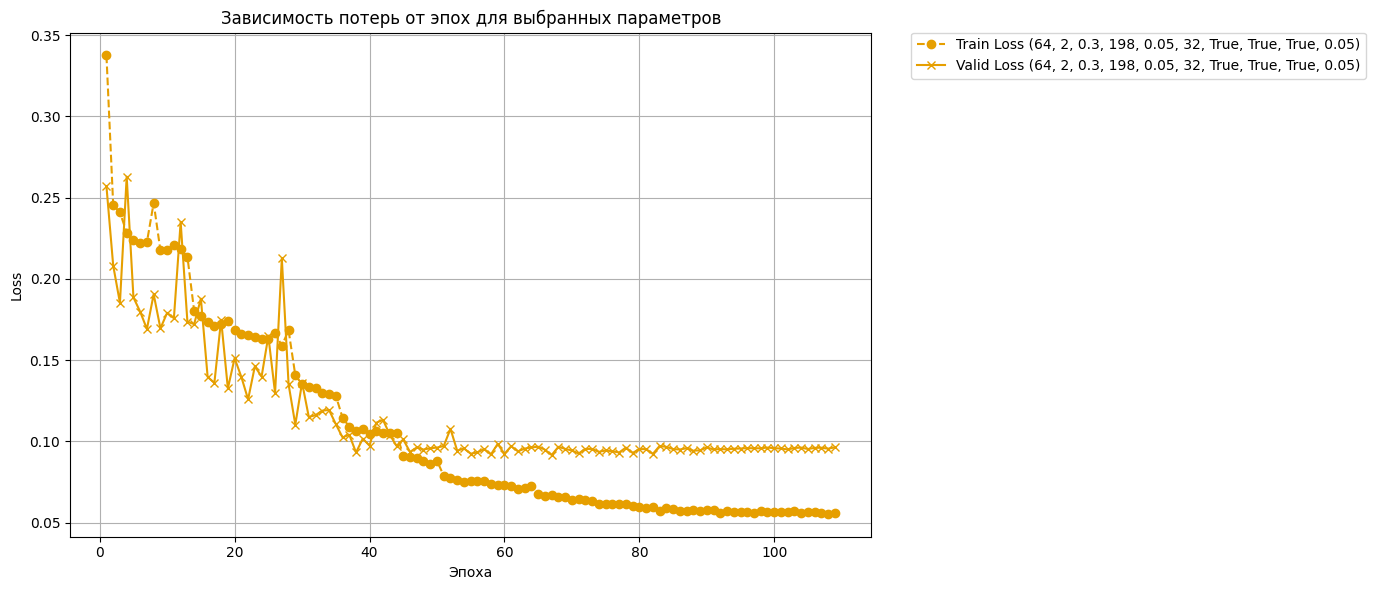

In [119]:
# Фильтрация по нескольким параметрам: hidden_dim, dropout, num_layers
plot_losses_by_param(
    results,
    param_filter=lambda params: (
        params[0] == default_params["hidden_dim"]
        and params[1] == default_params["num_layers"]
        and params[2] == default_params["dropout"]
        and params[3] == default_params["input_dim"]
        and params[4] == default_params["lr"]
        and params[5] == default_params["batch_length"]
        and params[6] == default_params["use_attention"]
        and params[7] == default_params["use_scheluder"]
        and params[8] == default_params["use_mask"]
        and params[9] == default_params["regularization"]
    ),
    use_smoothing=False,
)

# Тестрирование обученной модели

In [120]:
valid_results = []
for i in range(len(results)):
    print(i)
    valid_results.append(
        test_model_with_parameters(
            results, i, num_classes, valid_loader, device, 50, "valid"
        )
    )

/tmp/ipykernel_31/2270607856.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


0
(64, 2, 0.3, 198, 0.05, 32, True, True, True, 0.05)
BiLSTMModel(
  (input_embedding): Linear(in_features=198, out_features=64, bias=True)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Attention(
    (attention): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (fc_dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Model loaded from /kaggle/working/checkpoint_e6fe416eeb46d795dcd5e0398e73f95c.pt


Testing: 100%|██████████| 72/72 [00:00<00:00, 86.54batch/s, Test Loss=0.104] 


Accuracy: 0.9678
Precision: 0.9683
Recall: 0.9678
F1 Score: 0.9680
Confusion Matrix:
[[44438   104   986]
 [   47   684     0]
 [  692     1  9964]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     45528
           1       0.87      0.94      0.90       731
           2       0.91      0.93      0.92     10657

    accuracy                           0.97     56916
   macro avg       0.92      0.95      0.93     56916
weighted avg       0.97      0.97      0.97     56916



# Демонстрация ошибок

In [121]:
pred_labels_sequences = valid_results[0][6]
true_labels = valid_results[0][7]
pred_labels = valid_results[0][8]
pred_probs = valid_results[0][9]

In [122]:
over_true = [item for sublist in true_labels for item in sublist]
over_pred = [item for sublist in pred_labels for item in sublist]
over_prob = [item for sublist in pred_probs for item in sublist]

In [123]:
videos_lens = [calculating_data[video_idx]['num_frames']*3 // 25 * 25 for video_idx in valid_video]
videos_frames = [calculating_data[video_idx]['num_frames'] for video_idx in valid_video]
videos_fragments = [int(np.ceil(x / 3 / 25)) for x in videos_lens]
over_videos = [value for value, length in zip(valid_video, videos_frames) for _ in range(length)]

over_fragments = []
over_ranges = []
start = 0
fragments_full = 0
fragments = {}

for num_frames, max_fragment in zip(videos_frames, videos_fragments):
    num_full_segments = num_frames // length_train_sequence
    remaining_frames = num_frames % length_train_sequence

    # Добавляем полные сегменты
    for i in range(num_full_segments):
        end = start + length_train_sequence - 1
        over_fragments.extend([i] * length_train_sequence)
        fragments[fragments_full] = length_train_sequence
        over_ranges.extend([(start, end)] * length_train_sequence)
        start = end + 1
        fragments_full += 1
        

    # Добавляем оставшиеся кадры
    if remaining_frames > 0:
        end = start + remaining_frames - 1
        over_fragments.extend([num_full_segments] * remaining_frames)  
        over_ranges.extend([(start, end)] * remaining_frames)
        start = end + 1
        fragments[fragments_full] = remaining_frames
        fragments_full += 1

In [124]:
def find_true_fragments(labels, target_class):
    fragments = []
    start = None
    for i, label in enumerate(labels):
        if label == target_class:
            if start is None:
                start = i
        else:
            if start is not None:
                end = i - 1
                fragments.append((start, end))
                start = None
    if start is not None and (len(labels) - 1 > start) and (len(labels) - 1 - start) > 1:
        fragments.append((start, len(labels) - 1))
    return fragments

In [125]:
true_fragments = find_true_fragments(over_true, 1)
true_fragments[:10]

[(194, 199),
 (382, 387),
 (896, 900),
 (910, 913),
 (1600, 1604),
 (1777, 1781),
 (1788, 1792),
 (2260, 2264),
 (3079, 3084),
 (3246, 3250)]

In [126]:
over_fragments[true_fragments[1][0]:true_fragments[1][1]+1]

[15, 15, 15, 15, 15, 15]

In [127]:
over_videos[true_fragments[1][0]:true_fragments[1][1]+1]

[0, 0, 0, 0, 0, 0]

In [128]:
def find_predicted_fragments(labels, target_class):
    fragments = []
    start = None
    for i, label in enumerate(labels):
        if label == target_class:
            if start is None:
                start = i
        else:
            if start is not None:
                end = i - 1
                # Exclude fragments with same start and end (e.g., (350, 350))
                # and fragments with only 1-frame difference (e.g., (2559, 2560))
                # if end > start and (end - start) > 1:
                if end > start:
                    fragments.append((start, end))
                start = None
    if start is not None and (len(labels) - 1 > start) and (len(labels) - 1 - start) > 1:
        fragments.append((start, len(labels) - 1))
    return fragments

In [129]:
pred_fragments = find_predicted_fragments(over_pred, 1)
pred_fragments[:10]

[(194, 199),
 (382, 388),
 (896, 900),
 (910, 914),
 (1600, 1604),
 (1777, 1780),
 (1788, 1792),
 (2260, 2264),
 (3080, 3084),
 (3246, 3250)]

In [130]:
def find_reels_fragments(labels, target_class, batch_size):
    fragments = []

    # Параметры для поиска последовательностей
    start = None
    count = 0

    for i, label in enumerate(labels):
        if label == target_class:
            if start is None:
                start = i
            count += 1
        else:
            if start is not None and count >= 1:
                # Определяем индекс среднего элемента
                middle_index = start + count // 2

                # Определяем, к какому батчу относится средний элемент
                batch_index = middle_index // batch_size

                # Определяем начало и конец соседних батчей
                start_batch = max(0, (batch_index - 1) * batch_size)
                end_batch = min(len(labels) - 1, (batch_index + 2) * batch_size - 1)

                # Объединяем с предыдущим фрагментом, если они пересекаются
                if fragments and start_batch <= fragments[-1][1]:
                    # Обновляем конец последнего фрагмента
                    fragments[-1] = (fragments[-1][0], max(fragments[-1][1], end_batch))
                else:
                    # Добавляем новый фрагмент
                    fragments.append((start_batch, end_batch))

            # Сброс параметров
            start = None
            count = 0

    # Проверка для последней последовательности
    if start is not None and count >= 3:
        middle_index = start + count // 2
        batch_index = middle_index // batch_size
        start_batch = max(0, (batch_index - 1) * batch_size)
        end_batch = min(len(labels) - 1, (batch_index + 2) * batch_size - 1)

        # Объединяем с предыдущим фрагментом, если они пересекаются
        if fragments and start_batch <= fragments[-1][1]:
            fragments[-1] = (fragments[-1][0], max(fragments[-1][1], end_batch))
        else:
            fragments.append((start_batch, end_batch))

    return fragments

In [131]:
reels_fragments = find_reels_fragments(over_pred, 1, 25)
reels_fragments[:10]

[(150, 224),
 (350, 424),
 (850, 949),
 (1575, 1649),
 (1750, 1824),
 (2225, 2299),
 (3050, 3124),
 (3200, 3274),
 (3550, 3624),
 (4525, 4624)]

In [132]:
def check_detection(true_fragments, pred_fragments):
    detected_fragments = []
    missed_fragments = []
    extra_fragments = []
    matched_predicted_fragments = set()
    
    for true_frag in true_fragments:
        detected = False
        for pred_frag in pred_fragments:
            if true_frag[0] >= pred_frag[0] and true_frag[1] <= pred_frag[1]:
                detected_fragments.append(true_frag)
                matched_predicted_fragments.add(pred_frag)
                detected = True
                break
        if not detected:
            missed_fragments.append(true_frag)
                
    # Identify extra fragments that did not match any true fragment
    extra_fragments = [frag for frag in pred_fragments if frag not in matched_predicted_fragments]
    
    return {
        'detected_fragments': len(detected_fragments),
        'missed_fragments': len(missed_fragments),
        'extra_fragments': len(extra_fragments),
    }, detected_fragments, missed_fragments, extra_fragments    

In [133]:
results_evaluate, detected_fragments, missed_fragments, extra_fragments = check_detection(true_fragments, reels_fragments)

In [134]:
results_evaluate

{'detected_fragments': 157, 'missed_fragments': 2, 'extra_fragments': 15}

In [135]:
detected_fragments[:10]

[(194, 199),
 (382, 387),
 (896, 900),
 (910, 913),
 (1600, 1604),
 (1777, 1781),
 (1788, 1792),
 (2260, 2264),
 (3079, 3084),
 (3246, 3250)]

In [136]:
missed_fragments[:10]

[(14598, 14602), (41521, 41525)]

In [137]:
missed_fragments[:10]

[(14598, 14602), (41521, 41525)]

In [138]:
extra_fragments[:10]

[(4800, 4874),
 (14950, 15024),
 (15500, 15574),
 (15800, 15874),
 (20375, 20499),
 (28225, 28299),
 (28450, 28524),
 (32050, 32124),
 (36125, 36199),
 (37550, 37624)]

In [139]:
over_fragments[missed_fragments[1][0]:missed_fragments[1][1]+1]

[9, 9, 9, 9, 9]

In [140]:
over_videos[missed_fragments[1][0]:missed_fragments[1][1]+1]

[95, 95, 95, 95, 95]

In [141]:
for i in range(len(missed_fragments)):
    print('-'*30)
    print(over_fragments[missed_fragments[i][0]:missed_fragments[i][1]+1])
    print(over_videos[missed_fragments[i][0]:missed_fragments[i][1]+1])
    print(*over_prob[missed_fragments[i][0]-5:missed_fragments[i][0]], sep='\n', end='\n   ')
    print(*over_prob[missed_fragments[i][0]:missed_fragments[i][1]+1], sep='\n   ', end='\n')
    print(*over_prob[missed_fragments[i][1]+1:missed_fragments[i][1]+1+5], sep='\n')

------------------------------
[8, 8, 8, 8, 8]
[29, 29, 29, 29, 29]
[0.9999527931213379, 2.133359339495655e-05, 2.588770803413354e-05]
[0.9997273087501526, 8.571548096369952e-05, 0.00018701709632296115]
[0.999616265296936, 0.00010308881610399112, 0.0002806885167956352]
[0.9996826648712158, 7.21284159226343e-05, 0.0002452201151754707]
[0.9973771572113037, 0.0005568888154812157, 0.002065971726551652]
   [0.8217872381210327, 0.04633532464504242, 0.13187743723392487]
   [0.9438270926475525, 0.04970072582364082, 0.00647214287891984]
   [0.9525018930435181, 0.043556634336709976, 0.0039414591155946255]
   [0.9943588376045227, 0.00504768081009388, 0.0005935367662459612]
   [0.9991000890731812, 0.0008099277038127184, 9.000723366625607e-05]
[0.9998192191123962, 0.00010352741810493171, 7.726327021373436e-05]
[0.9995846152305603, 0.00012906971096526831, 0.0002863940899260342]
[0.9995075464248657, 0.00011507354793138802, 0.00037730098119936883]
[0.9993743300437927, 0.00019612062897067517, 0.0004296

In [142]:
def evaluate_detection(detected_fragments, true_fragments, extra_fragments):
   
    recall = len(detected_fragments) / len(true_fragments) if true_fragments else 0
    precision = len(detected_fragments) / (len(detected_fragments) + len(extra_fragments)) if detected_fragments else 0
    f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0
    
    # Return metrics along with lists of fragment types
    return {
        'recall': round(recall, 2),
        'precision': round(precision, 2),
        'f1_score': round(f1_score, 2),
    }

In [143]:
metrics = evaluate_detection(detected_fragments, true_fragments, extra_fragments)
metrics

{'recall': 0.99, 'precision': 0.91, 'f1_score': 0.95}

# Тестирование на неизвестных видео 38

In [144]:
test_video = list(range(0, 6))

In [145]:
calculating_data_v38 = torch.load(f"{destination_input}/fsva-main-data/processed_data_s3_0_5_v38.pt", weights_only=False)
calculating_data_v38.keys()

dict_keys([0, 1, 2, 3, 4, 5])

In [146]:
v38_data = pd.read_csv(f"{destination_input}fsva-processed-elements/processed_elements_v38.csv")
v38_data.shape

(110, 7)

In [147]:
v38_data[v38_data.index_video == 0]

,index_video,coarse_class,element_item,frame_start,frame_end,frames,max_frames
0,0,no_action,Skating/Sequence,0,509,510,6551
1,0,jump,UN,510,519,10,6551
2,0,no_action,Skating/Sequence,520,1231,712,6551
3,0,jump,UN,1232,1242,11,6551
4,0,no_action,Skating/Sequence,1243,1678,436,6551
5,0,jump,UN,1679,1690,12,6551
6,0,no_action,Skating/Sequence,1691,2000,310,6551
7,0,jump,UN,2001,2011,11,6551
8,0,no_action,Skating/Sequence,2012,2257,246,6551
9,0,spin,UN,2258,2538,281,6551


In [148]:
test_labels = get_encoded_video(v38_data, test_video, step)

In [149]:
len(test_labels[1])

1941

In [150]:
test_fragmenter = SequenceFragmenter(test_labels)
test_fragments, test_fragments_count = test_fragmenter.split_into_fragments(length_train_sequence)
test_fragments_count

{frozenset({0}): 317,
 frozenset({0, 1}): 33,
 frozenset({0, 2}): 29,
 frozenset({2}): 29}

In [151]:
test_data = prepare_data(test_fragments, test_labels, calculating_data_v38, augment=False)

In [152]:
test_dataset = MLDataset(test_data)

In [153]:
test_loader = DataLoader(
    test_dataset,
    batch_size=parameters[5],
    shuffle=False,
    collate_fn=collate_ml,
)

In [154]:
test_results = []
for i in range(len(results)):
    print(i)
    test_results.append(
        test_model_with_parameters(
            results, i, num_classes, test_loader, device, 50, "test"
        )
    )

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_31/2270607856.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of t

0
(64, 2, 0.3, 198, 0.05, 32, True, True, True, 0.05)
BiLSTMModel(
  (input_embedding): Linear(in_features=198, out_features=64, bias=True)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Attention(
    (attention): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (fc_dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Model loaded from /kaggle/working/checkpoint_e6fe416eeb46d795dcd5e0398e73f95c.pt


Testing: 100%|██████████| 13/13 [00:00<00:00, 84.41batch/s, Test Loss=0.136]


Accuracy: 0.9666
Precision: 0.9688
Recall: 0.9666
F1 Score: 0.9672
Confusion Matrix:
[[8670   22  216]
 [  32   80    1]
 [  67    0 1034]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8908
           1       0.78      0.71      0.74       113
           2       0.83      0.94      0.88      1101

    accuracy                           0.97     10122
   macro avg       0.87      0.87      0.87     10122
weighted avg       0.97      0.97      0.97     10122



# Демонстрация ошибок

In [155]:
test_pred_labels_sequences = test_results[0][6]
test_true_labels = test_results[0][7]
test_pred_labels = test_results[0][8]
test_pred_probs = test_results[0][9]

In [156]:
test_over_true = [item for sublist in test_true_labels for item in sublist]
test_over_pred = [item for sublist in test_pred_labels for item in sublist]
test_over_prob = [item for sublist in test_pred_probs for item in sublist]

In [157]:
len(test_over_true)

10122

In [158]:
len(test_over_pred)

10122

In [159]:
test_videos_lens = [calculating_data_v38[video_idx]['num_frames']*3 // 25 * 25 for video_idx in test_video]
test_videos_frames = [calculating_data_v38[video_idx]['num_frames'] for video_idx in test_video]
test_videos_fragments = [int(np.ceil(x / 3 / 25)) for x in test_videos_lens]
test_over_videos = [value for value, length in zip(test_video, test_videos_frames) for _ in range(length)]

test_over_fragments = []
test_over_ranges = []
start = 0
fragments_full = 0
fragments = {}

for num_frames, max_fragment in zip(test_videos_frames, test_videos_fragments):
    num_full_segments = num_frames // length_train_sequence
    remaining_frames = num_frames % length_train_sequence

    # Добавляем полные сегменты
    for i in range(num_full_segments):
        end = start + length_train_sequence - 1
        test_over_fragments.extend([i] * length_train_sequence)
        fragments[fragments_full] = length_train_sequence
        test_over_ranges.extend([(start, end)] * length_train_sequence)
        start = end + 1
        fragments_full += 1
        

    # Добавляем оставшиеся кадры
    if remaining_frames > 0:
        end = start + remaining_frames - 1
        test_over_fragments.extend([num_full_segments] * remaining_frames)  
        test_over_ranges.extend([(start, end)] * remaining_frames)
        start = end + 1
        fragments[fragments_full] = remaining_frames
        fragments_full += 1

In [160]:
test_true_fragments = find_true_fragments(test_over_true, 1)
test_true_fragments[:10]

[(170, 173),
 (411, 414),
 (560, 563),
 (667, 670),
 (1055, 1057),
 (1196, 1198),
 (1209, 1211),
 (1216, 1218),
 (1575, 1576),
 (1652, 1655)]

In [161]:
test_over_fragments[test_true_fragments[1][0]:test_true_fragments[1][1]+1]

[16, 16, 16, 16]

In [162]:
test_over_videos[test_true_fragments[1][0]:test_true_fragments[1][1]+1]

[0, 0, 0, 0]

In [163]:
test_pred_fragments = find_predicted_fragments(test_over_pred, 1)
test_pred_fragments[:10]

[(411, 414),
 (560, 563),
 (667, 671),
 (1054, 1059),
 (1196, 1199),
 (1209, 1211),
 (1215, 1218),
 (1652, 1655),
 (1665, 1668),
 (2807, 2811)]

In [164]:
test_reels_fragments = find_reels_fragments(test_over_pred, 1, 25)
test_reels_fragments[:10]

[(375, 449),
 (525, 599),
 (625, 699),
 (1025, 1099),
 (1150, 1249),
 (1625, 1699),
 (2775, 2849),
 (2900, 2999),
 (3175, 3249),
 (4400, 4474)]

In [165]:
test_results_evaluate, test_detected_fragments, test_missed_fragments, test_extra_fragments = check_detection(test_true_fragments, test_reels_fragments)

In [166]:
test_results_evaluate

{'detected_fragments': 27, 'missed_fragments': 9, 'extra_fragments': 0}

In [167]:
test_detected_fragments[:10]

[(411, 414),
 (560, 563),
 (667, 670),
 (1055, 1057),
 (1196, 1198),
 (1209, 1211),
 (1216, 1218),
 (1652, 1655),
 (1666, 1668),
 (2807, 2810)]

In [168]:
test_missed_fragments[:10]

[(170, 173),
 (1575, 1576),
 (2309, 2312),
 (2561, 2563),
 (4715, 4717),
 (4918, 4920),
 (5323, 5324),
 (5592, 5593),
 (6074, 6076)]

In [169]:
test_missed_fragments[:10]

[(170, 173),
 (1575, 1576),
 (2309, 2312),
 (2561, 2563),
 (4715, 4717),
 (4918, 4920),
 (5323, 5324),
 (5592, 5593),
 (6074, 6076)]

In [170]:
test_extra_fragments[:10]

[]

In [171]:
test_over_fragments[test_missed_fragments[1][0]:test_missed_fragments[1][1]+1]

[63, 63]

In [172]:
test_over_videos[test_missed_fragments[1][0]:test_missed_fragments[1][1]+1]

[0, 0]

In [173]:
for i in range(len(test_missed_fragments)):
    print('-'*30)
    print(test_over_fragments[test_missed_fragments[i][0]:test_missed_fragments[i][1]+1])
    print(test_over_videos[test_missed_fragments[i][0]:test_missed_fragments[i][1]+1])
    print(*test_over_prob[test_missed_fragments[i][0]-5:test_missed_fragments[i][0]], sep='\n', end='\n   ')
    print(*test_over_prob[test_missed_fragments[i][0]:test_missed_fragments[i][1]+1], sep='\n   ', end='\n')
    print(*test_over_prob[test_missed_fragments[i][1]+1:test_missed_fragments[i][1]+1+5], sep='\n')

------------------------------
[6, 6, 6, 6]
[0, 0, 0, 0]
[0.9998979568481445, 5.7057233789237216e-05, 4.4979100493947044e-05]
[0.9999029636383057, 5.196587881073356e-05, 4.510449798544869e-05]
[0.9998797178268433, 5.335605965228751e-05, 6.685510743409395e-05]
[0.9998249411582947, 4.6020086301723495e-05, 0.00012909065117128193]
[0.9996321201324463, 8.015128696570173e-05, 0.0002876707585528493]
   [0.9962397813796997, 0.003368058707565069, 0.00039209556416608393]
   [0.9573623538017273, 0.04245731979608536, 0.00018037183326669037]
   [0.9278513193130493, 0.07185027003288269, 0.00029841859941370785]
   [0.9594751596450806, 0.03909669816493988, 0.0014280847972258925]
[0.9889642000198364, 0.004417276941239834, 0.006618548184633255]
[0.9992470741271973, 0.00018206829554401338, 0.0005709011456929147]
[0.9999204874038696, 3.729636955540627e-05, 4.215653461869806e-05]
[0.9999030828475952, 6.047391798347235e-05, 3.65148953278549e-05]
[0.9998879432678223, 6.678728095721453e-05, 4.5282769860932603

In [174]:
test_metrics = evaluate_detection(test_detected_fragments, test_true_fragments, test_extra_fragments)
test_metrics

{'recall': 0.75, 'precision': 1.0, 'f1_score': 0.86}